The Iris Dataset contains four features (length and width of sepals and petals) of 50 samples of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). These measures were used to create a linear discriminant model to classify the species.

In [ ]:
# Before we start - simple example
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, y)

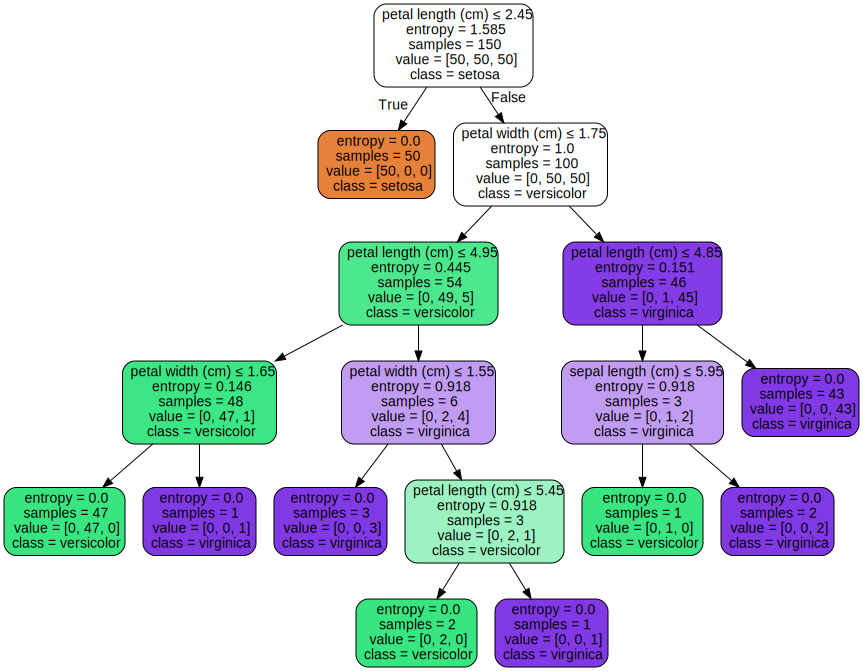

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=iris.feature_names,  
                      class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Data description:

# Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# Name - Name
# Sex - Sex
# Age - Age
# Sibsp - Number of Siblings/Spouses Aboard
# Parch - Number of Parents/Children Aboard
# Ticket - Ticket Number
# Fare - Passenger Fare
# Cabin - Cabin
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [ ]:
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [ ]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

KeyError: ignored

## Visualising processed data ##

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


Our dataset is now much cleaner than before, with only numerical values and potentially meaningful features.

In [ ]:
# colormap = plt.cm.viridis
# plt.figure(figsize=(12,12))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

*Title* VS *Sex*
-------

In [ ]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['count', 'sum','mean'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived               
         count  sum      mean
Title                        
1          517   81  0.156673
2           40   23  0.575000
3          126  100  0.793651
4          185  130  0.702703
5           23    8  0.347826

In [ ]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

The data shows that less 'Mr' survived (15.67%) than men in general (18.89%): *Title* seems therefore to be more useful than *Sex* for our purpose. This may be because *Title* implicitly includes information about *Sex* in most cases. To verify this, we can use the copy we made of the original training data without mappings and check the distribution of *Sex* grouped by *Title*.

In [ ]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

We find that, excepting for a single observation (a female with 'Dr' title), all the observations for a given *Title* share the same *Sex*. Therefore the feature *Title* is capturing all the information present in *Sex*. In addition, *Title* may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality, ...

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
tree_model = tree.DecisionTreeClassifier(criterion='entropy',max_depth = 2,min_samples_leaf=3)
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived'], axis=1), train["Survived"], test_size = 0.3, random_state = 0)

#fit a model
tree_model.fit(X = X_train, y = y_train)

# Predicting results for train dataset
y_pred_train = tree_model.predict(X_train)
# Predicting results for test dataset
y_pred_test = tree_model.predict(X_test)

# Model Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


Train Accuracy: 0.8250401284109149
Test Accuracy: 0.7985074626865671


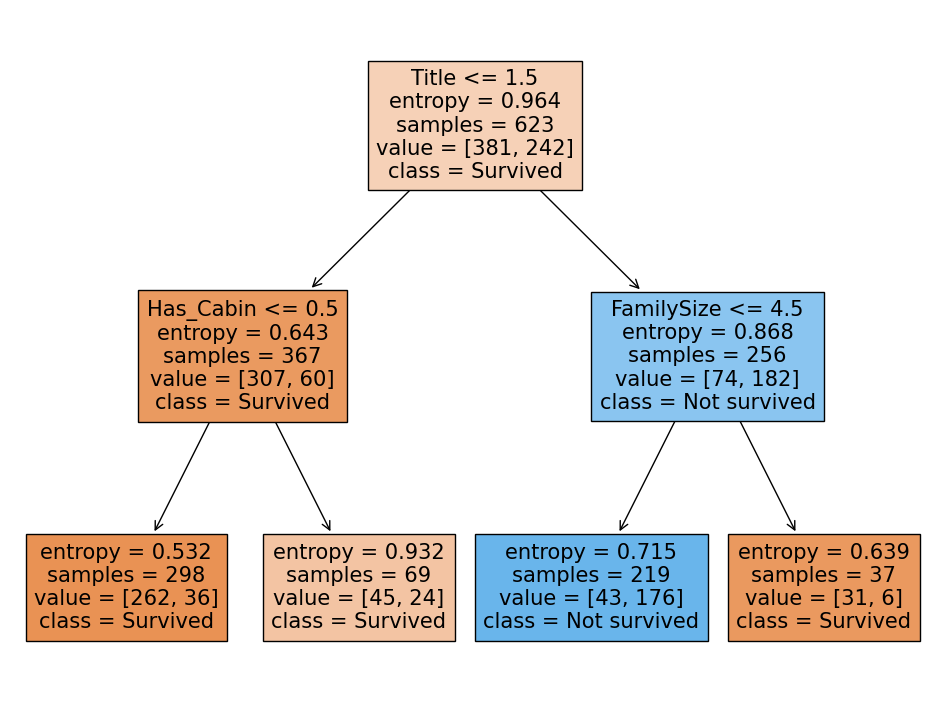

In [ ]:
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
fig = plt.figure(figsize=(12,9))
_ = tree.plot_tree(tree_model, 
                   feature_names=X_train.columns,  
                   class_names=['Survived', 'Not survived'],
                   filled=True)

# Visualize decision tree using graphviz
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data, filled=True, rounded=True,
                feature_names=X_train.columns,  
                class_names=['Survived', 'Not survived'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(4,3))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15)

NameError: ignored

<Figure size 400x300 with 0 Axes>

## Finding best tree depth with the help of Cross Validation ##

In [ ]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth,criterion='entropy')
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.789076
         3          0.831648
         4          0.828277
         5          0.828290
         6          0.813745
         7          0.803658
         8          0.807016
         9          0.804769
        10          0.811511


The best *max_depth* parameter seems therefore to be 3 (82.8% average accuracy across the 10 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 3 as the *max_depth* parameter for our final model.

## Final Tree ##

In [ ]:
tree_classifier = DecisionTreeClassifier(max_depth=3, criterion='entropy')
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
import dtreeviz
viz_model = dtreeviz.model(tree_classifier,
                           X_train=X_train, y_train=y_train,
                           feature_names=X_train.columns.values,
                           target_name='Survived', class_names=["perish", "survive"])

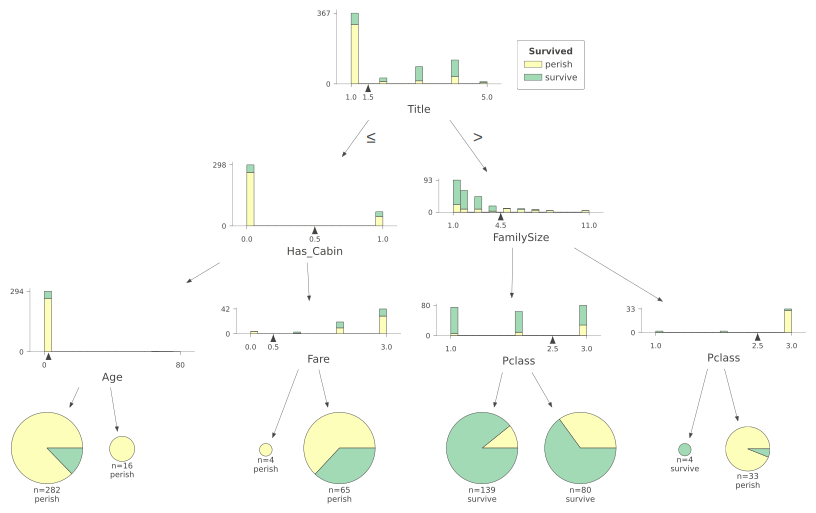

In [ ]:
import warnings
import logging
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
viz_model.view(scale=1.2)
#title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Finally, here we have our *Decision Tree*! It achieves an accuracy of 82.38% across the training dataset. Let's begin explaining how to read the graph.


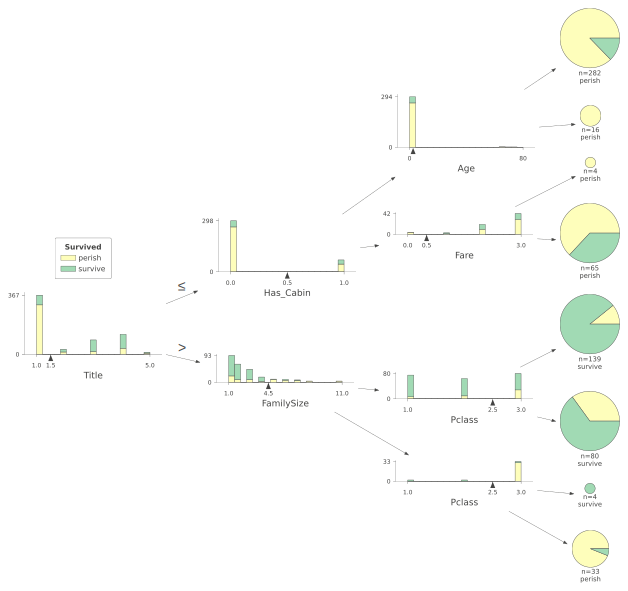

In [ ]:
viz_model.view(orientation="LR")

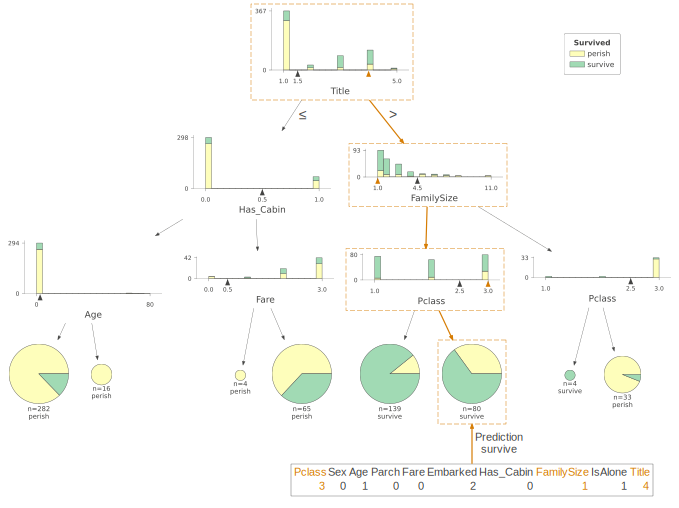

In [ ]:
x = X_train.iloc[10]
viz_model.view(x=x)

In [ ]:
y_train.iloc[10]

1